# Beijing Housing Deep Learning - Leandro Gregorini

>Environment to run this notebook is available at **environment.yml**

## Inhaltsverzeichnis

* [Imports](#Imports)
* [Analyse](#Analyse)
* [Modell](#Modell)
    * [Datensatz laden](#DatensatzLaden)
    * [Feature Importance](#FeatureImportance)
    * [Optimizer vorbereiten](#OptimizerVorbereiten)
    * [Modell initialisieren](#ModellInitialisieren)
    * [Modell visualisieren](#ModellVisualisieren)
    * [Modell erstellen](#ModellErstellen)
    * [Modell evaluieren](#ModellEvaluieren)
    * [Modell optimieren](#ModellOptimieren)

## Imports <a class="anchor" id="Imports"></a>

In [2]:
# deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
import keras_tuner
from tensorflow.keras import regularizers

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# data handling
import numpy as np
import pandas as pd

# visualisierung
%matplotlib inline
import matplotlib.pyplot as plt
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer

TensorFlow version: 2.4.1


In [3]:
#run_count = 0

In [4]:
# run count for documentation purposes and figure naming
try:
    run_count
except NameError:
    run_count = 0

run_count += 1

print("run_count:", run_count)

run_count: 1


---

## Deep Learning Modell für den Beijing Datensatz <a class="anchor" id="Modell"></a>

### Analyse der Parameter und Begründungen <a class="anchor" id="Analyse"></a>

- **Hidden Layers**
    - **Beschreibung**: <br>
Die mittlere Schicht bzw. Schichten eines Deep Learning Netzwerks werden als "Hidden Layers" bezeichnet.
Die Neuronen dieser Schichten sind weder "Inputs" noch "Outputs".
Die notwendige Anzahl von Ebenen kann beliebig festgelegt werden und es ist oft schwer die "beste" Anzahl zu finden (oft werden jedoch 2 eingesetzt).
<br><br>
<br> Die gängigsten Fälle die eintreten:
<br>- 0 Hidden Layers: Nur in der Lage linear trennbare Funktionen oder Entscheidungen darzustellen
<br>- 1 Hidden Layer: Kann jede Funktion annähern, die eine kontinuierliche Abbildung von einem endlichen Raum zu einem anderen enthält
<br>- 2 Hidden Layers: Kann mit rationalen Aktivierungsfunktionen eine beliebige Entscheidungsgrenze mit beliebiger Genauigkeit darstellen
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Nodes**
    - **Beschreibung** <br>
Mit der Anzahl Nodes legt man fest, wie viele Neuronen in den verschiedenen Schichten eingesetzt werden. Die Input-Nodes ergeben sich aus der Problemstellung, im Fall vom MNIST Datensatz sind es 784 Neuronen (28x28), diese Zahl wird durch die Anzahl Pixel der Bilder vorgegeben. Die Output-Nodes werden ebenfalls auf die Problemstellung angepasst, im Fall vom MNIST Datensatz sind es 10 Neuronen, da man eine Zahl zwischen 0 und 10 vorhersagen möchte.
<br><br>
<br> Die Anzahl Hidden-Nodes können mit folgenden Faustregeln festgelegt werden:
<br>- Die Anzahl der Hidden-Nodes sollte zwischen der Anzahl Nodes im Input- und Output Layer liegen
<br>- Die Anzahl der Hidden-Nodes sollte 2/3 der Anzahl Nodes im Input Layer plus der Anzahl Nodes im Output Layer sein
<br>- Die Anzahl der Hidden-Nodes sollte weniger als die doppelte Anzahl an Nodes im Input Layer sein.
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Batches**
    - **Beschreibung** <br>
Die batch size definiert die Anzahl an Trainingsdaten, die durch das Netzwerk in einer "Iteration" weitergegeben werden.
<br><br>
Vorteile für das Verwenden einer batch size < Anzahl aller Trainingsdaten:
<br>- Es erfordert weniger Speicher
<br>- Typischerweise trainieren Netzwerke mit Mini-Batches schneller.
<br>
Nachteile:
<br>- Umso kleiner der Batch ist, desto ungenauer wird die Schätzung des Gradienten sein. 
<br><br> Folgende Batch sizes können je nach Hardware eingesetzt werden:
<br>- 1, 2, 4, 8, 16 - eher lange Trainingszeit
<br>- 32 oder 64 - Beim Rechnen mit CPU
<br>- 128 oder 256 - Beim Rechnen mit GPU
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Epochs**
    - **Beschreibung** <br>
Ein kompletter Durchlauf aller Input-Daten wird als Epoche bezeichnet. Dabei können die Input-Daten je nach Größe des Datensatzes auch in gleich große Gruppen (Batches) eingeteilt werden und das Training kann jeweils pro Batch durchgeführt werden.
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Activation function**
    - **Beschreibung** <br>
Die Wahl der Aktivierungsfunktion im Hidden Layer bestimmt, wie gut das Modell den Trainingsdatensatz erlernt.
<br><br>
Folgende Funktionen gibt es für die Hidden Layers:
<br>- Rectified Linear Activation (ReLU)
<br>- Logistic (Sigmoid)
<br>- Hyperbolic Tangent (Tanh)
<br><br>
Folgende Funktionen gibt es für den Output Layer:
<br>- Regression: linear
<br>- Klassifikation: softmax oder sigmoid (sollte nur verwendet werden, wenn mehrere Outputs als "richtige" Antworten gelten sollen)
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Regularization**
    - **Beschreibung** <br>
Mit Regularisierung möchte man Overfitting in neuronalen Netzen reduzieren und somit die Genauigkeit eines Deep Learning Modells bei Anwendung auf komplett neue Daten verbessern.
<br><br>
Es gibt verschiedene Arten der Regularisierung:
<br>- L1-Regularisierung: Kann als eine Art Neuronenselektion betrachtet werden, da sie die Gewichte einiger versteckter Neuronen auf Null bringt.
<br>- L2-Regularisierung: Die Werte der Gewichte werden gegen Null gebracht, was zu einem einfacheren Modell führt.
<br>- Dropout: Die Idee der Dropout-Regularisierung besteht darin, einige Knoten nach dem Zufallsprinzip zu entfernen. Wie bei der L2-Regularisierung vereinfacht sich das Modell und die Komplexität wird somit reduziert.
    <br><br>
    - **Begründung der Auswahl** <br>

<br><br>
- **Optimizer**
    - **Beschreibung** <br>
Optimizer sind Algorithmen oder Methoden, die zur Minimierung einer Fehlerfunktion (Verlustfunktion) oder zur Maximierung der Effizienz eingesetzt werden (Oft "Gradient descent"). Optimizer sind mathematische Funktionen, die von den Parametern des Modells abhängen, d.h. von den weights und biases.
<br> Im Keras Paket gibt es viele Optimizer, welche verwendet werden können, diese sind in der <a href="https://keras.io/api/optimizers/">Dokumentation</a> genauer beschrieben.
<br><br>
Grobe Übersicht:
<br>- Gradient Descent: Batch gradient descent, stochastic gradient descent, mini-batch gradient descent
<br>- Adaptive: Adagrad, Adadelta, RMSprop, Adam
    <br><br>
    - **Begründung der Auswahl** <br>


### Datensatz laden <a class="anchor" id="DatensatzLaden"></a>

In [5]:
# Preprocessed Daten laden
trainDF = pd.read_csv('../../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../../app/data/02_test.csv', sep=';')

In [6]:
trainDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,347.0
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,317.0
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,301.5
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,405.0
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,670.0


In [7]:
x_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
x_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [8]:
print(f'Shape x_train : {x_train.shape}')
print(f'Shape x_test : {x_test.shape}')
print(f'Shape y_train : {y_train.shape}')
print(f'Shape y_test : {y_test.shape}')

Shape x_train : (219943, 26)
Shape x_test : (94262, 26)
Shape y_train : (219943,)
Shape y_test : (94262,)


### Feature Importance <a class="anchor" id="FeatureImportance"></a>

best_features: ['square', 'livingRoom', 'bathRoom', 'communityAverage', 'districtArea', 'tradeYear', 'tradeMonth']


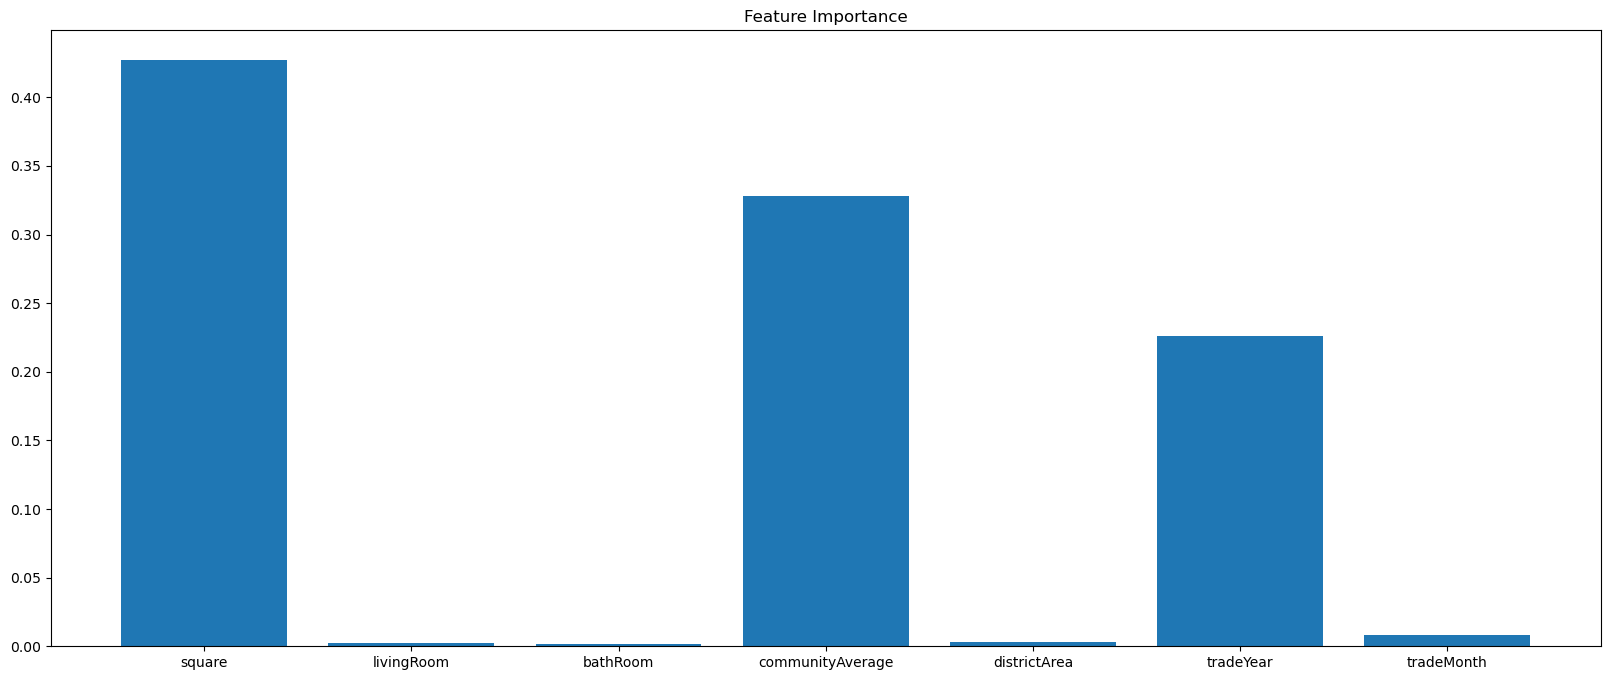

In [9]:
def plot_gb_feature_importance(gb_x_train, min_value=0):
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(gb_x_train, y_train.values.ravel())
    gb_df = pd.DataFrame(gb.feature_importances_, index = gb_x_train.columns.to_list(), columns = ['feature_importance'])  # save scores to df    
    filtered_gb_df = gb_df[gb_df["feature_importance"]>min_value]
    best_features = filtered_gb_df.index.to_list()

    fig = plt.figure(figsize=(20,8))
    plt.bar(filtered_gb_df.index, filtered_gb_df["feature_importance"])
    plt.title("Feature Importance")
    plt.plot()
    return best_features

features_to_analyze = x_train.columns.to_list()
gb_x_train = x_train[features_to_analyze]
best_features = plot_gb_feature_importance(gb_x_train=gb_x_train, min_value=0.001)
print("best_features:", best_features)

In [10]:
x_train = x_train[best_features]
x_test = x_test[best_features]

### Optimizer vorbereiten <a class="anchor" id="OptimizerVorbereiten"></a>

In [11]:
# Funktion für Optimizer je nach Auswahl in der Konfiguration
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None

    if optimizer_name == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    return optimizer

### Modell initialisieren <a class="anchor" id="ModellInitialisieren"></a>

> Code-Snippets aus Kurs CDS-108 (siehe Referenzen unten im Dokument)

In [12]:
# Konfiguration des Models (gespeichert in einem dict)
model_config = {
            "INPUT_SHAPE" : (x_train.shape[1],),                # Form des Inputs (Für Boston Housing: Anzahl features)
            "HIDDEN_NODES" : [4,4],                           # Anzahl Neuronen im Hidde Layer (Es werden 2 Hidden-Layers eingesetzt) -> ungefähr 2/3 der Anzahl Input Nodes + Anzahl Output Nodes
            "HIDDEN_ACTIVATION" : "relu",                       # Aktivierungsfunktion im Hidden Layer
            "OUTPUT_NODES" : 1,                                 # Output nodes des Output Layers
            "OUTPUT_ACTIVATION" : None,
            "WEIGHTS_INITIALIZER" : "random_normal",            # Initialisierung der Gewichte
            "BIAS_INITIALIZER" : "ones",                        # Initialisierung des Bias
            "NORMALIZATION" : "none",                           # Normalisierung
            "OPTIMIZER" : "rmsprop",                            # Root Mean Square Propagation
            "LEARNING_RATE" : 0.01,                             # Lernrate für "Gradient descent" (0.01 oder 0.1 meist standard)
            "REGULARIZER" : None,                               # Regularisierung (L1, L2)
            "DROPOUT_RATE" : 0.25,                              # Regularisierung (Dropout)
            "DROPOUT": True,                                    # Dropout verwenden oder nicht
            "EPOCHS" : 15,                                      # Anzahl der Epochen, welche trainiert werden sollen
            "BATCH_SIZE" : 16,                                  # Anzahl Daten pro batch
            "VALIDATION_SPLIT" : 0.2,                           # Grösse des Validierungs-Datensatzes
            "VERBOSE" : 1,                                      # Bestimmt die Ausgabe von Infos beim Tranieren des Modells (verbose=0: silent, verbose=1: animierte Anzeige, verbose=2: Zeigt nur die Anzahl Epochen an, welche abgearbeitet wurden)
            "LOSS_FUNCTION" : "mse",                            # Kostenfunktion (MSE für Regression)
            "METRICS" : ["MeanSquaredError"]                    # Optimierungs-Metrik
            }

In [13]:
def prepare_model(model_name, model_config):
    model=tf.keras.models.Sequential(name=model_name)  # Keras Layers in sequentieller Ordnung aufbauen

    for layer in range(len(model_config["HIDDEN_NODES"])):  # Anzahl Hidden Layers
        if layer == 0:
            # Erster Hidden Layer und Input Layer hinzufügen
            model.add(
                    tf.keras.layers.Dense(units=model_config["HIDDEN_NODES"][layer],
                    input_shape=model_config["INPUT_SHAPE"],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            # Weitere Hidden Layers hinzufügen
            model.add(
                    tf.keras.layers.Dense(units=model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
            
            # Weitere Layers hinzufügen
            if model_config["NORMALIZATION"] == "batch":
                model.add(tf.keras.layers.BatchNormalization())

            if model_config["DROPOUT"]:
                model.add(tf.keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
    model.add(tf.keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))

    optimizer = get_optimizer(model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])

    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    return model

In [14]:
model = prepare_model(model_name = "BEIJING-MODEL", model_config = model_config)  # load/prepare model

2023-03-22 13:49:26.054354: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-22 13:49:26.055167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-22 13:49:26.061303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 13:49:26.061461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:42:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-22 13:49:26.061475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-22 13:49:26.062580: I tensorflow/stream_executor/platfor

### Modell visualisieren <a class="anchor" id="ModellVisualisieren"></a>

In [15]:
visualizer(model, file_name="BEIJING-MODEL", file_format='png')  # visualizer from keras_visualizer package

<img src="BEIJING-MODEL.png">

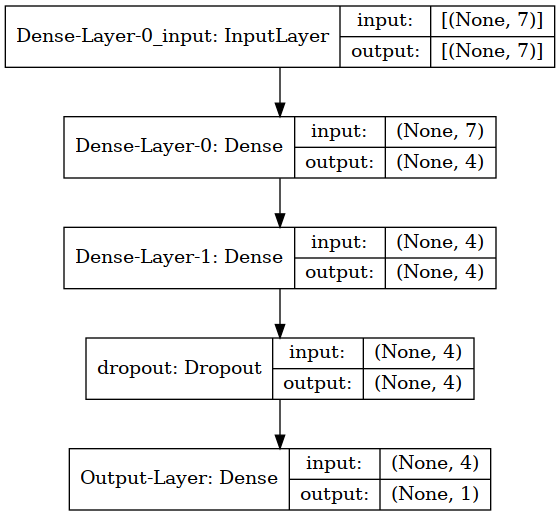

In [16]:
plot_model(model, to_file="BEIJING-MODEL_KERAS.png", show_shapes=True, show_layer_names=True)  # visualizer integrated in keras package

### Modell erstellen und trainieren <a class="anchor" id="ModellErstellen"></a>

In [17]:
model.summary()

Model: "BEIJING-MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense-Layer-0 (Dense)        (None, 4)                 32        
_________________________________________________________________
Dense-Layer-1 (Dense)        (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
Output-Layer (Dense)         (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [18]:
def run_model(model, x_train, y_train, stratify):
    X_train, X_val, Y_train, Y_val = train_test_split(
                            x_train, y_train,
                            stratify=stratify,
                            test_size=model_config["VALIDATION_SPLIT"])

    history=model.fit(X_train,
              Y_train,
              batch_size=model_config["BATCH_SIZE"],
              epochs=model_config["EPOCHS"],
              verbose=model_config["VERBOSE"],
              validation_data= (X_val, Y_val))
    return history, model, X_train, Y_train, X_val, Y_val

In [19]:
history, model, X_train, Y_train, X_val, Y_val = run_model(model=model, x_train=x_train, y_train=y_train, stratify=None)  # save trained model and data

2023-03-22 13:49:27.099108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-22 13:49:27.118011: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393155000 Hz


Epoch 1/15
    1/10998 [..............................] - ETA: 1:24:33 - loss: 341248.4375 - mean_squared_error: 341248.4375

2023-03-22 13:49:27.433885: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


10998/10998 [==============================] - 21s 2ms/step - loss: 65269.6286 - mean_squared_error: 65269.6286 - val_loss: 22620.7305 - val_mean_squared_error: 22620.7305
Epoch 2/15
10998/10998 [==============================] - 21s 2ms/step - loss: 38550.3891 - mean_squared_error: 38550.3891 - val_loss: 20673.7168 - val_mean_squared_error: 20673.7168
Epoch 3/15
10998/10998 [==============================] - 21s 2ms/step - loss: 33970.3161 - mean_squared_error: 33970.3161 - val_loss: 24703.6543 - val_mean_squared_error: 24703.6543
Epoch 4/15
10998/10998 [==============================] - 21s 2ms/step - loss: 32503.5661 - mean_squared_error: 32503.5661 - val_loss: 21375.7227 - val_mean_squared_error: 21375.7227
Epoch 5/15
10998/10998 [==============================] - 20s 2ms/step - loss: 30971.9413 - mean_squared_error: 30971.9413 - val_loss: 21882.4336 - val_mean_squared_error: 21882.4336
Epoch 6/15
10998/10998 [==============================] - 21s 2ms/step - loss: 29855.9000 - mean

### Modell evaluieren <a class="anchor" id="ModellEvaluieren"></a>

In [20]:
print("\n------------------------------------------------------------------------------")
print("Scores")
print("------------------------------------------------------------------------------\n")
print("Train data")
print("x_train MSE:", model.evaluate(X_train, Y_train, verbose=2)[0])
print("\n------------------------------------------------------------------------------")
print("Test data")
print("x_test MSE:", model.evaluate(x_test, y_test, verbose=2)[0])
print("\n------------------------------------------------------------------------------")
print("Validation data")
print("x_val MSE:", model.evaluate(X_val, Y_val, verbose=2)[0])


------------------------------------------------------------------------------
Scores
------------------------------------------------------------------------------

Train data
5499/5499 - 3s - loss: 22753.1426 - mean_squared_error: 22753.1426
x_train MSE: 22753.142578125

------------------------------------------------------------------------------
Test data
2946/2946 - 2s - loss: 22031.6172 - mean_squared_error: 22031.6172
x_test MSE: 22031.6171875

------------------------------------------------------------------------------
Validation data
1375/1375 - 1s - loss: 21517.1152 - mean_squared_error: 21517.1152
x_val MSE: 21517.115234375


In [21]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [22]:
def plot_measures_regression(model_name, history=history, title="Measures", accuracy_measures_to_plot=["train_loss", "train_mean_squared_error", "val_loss", "val_mean_squared_error"], savefig=False):
    accuracy_measures={}
    accuracy_measures["train_loss"] = history.history["loss"]
    accuracy_measures["train_mean_squared_error"] = history.history["mean_squared_error"]
    accuracy_measures["val_loss"] = history.history["val_loss"]
    accuracy_measures["val_mean_squared_error"] = history.history["val_mean_squared_error"]
    plt.figure(figsize=(15, 8))
    for measure in accuracy_measures.keys():
        if measure in accuracy_measures_to_plot:
            plt.plot(accuracy_measures[measure], label=measure, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Measure")
    plt.legend()
    if savefig:
        plt.savefig(f'figures/{title}.png')
    plt.show()

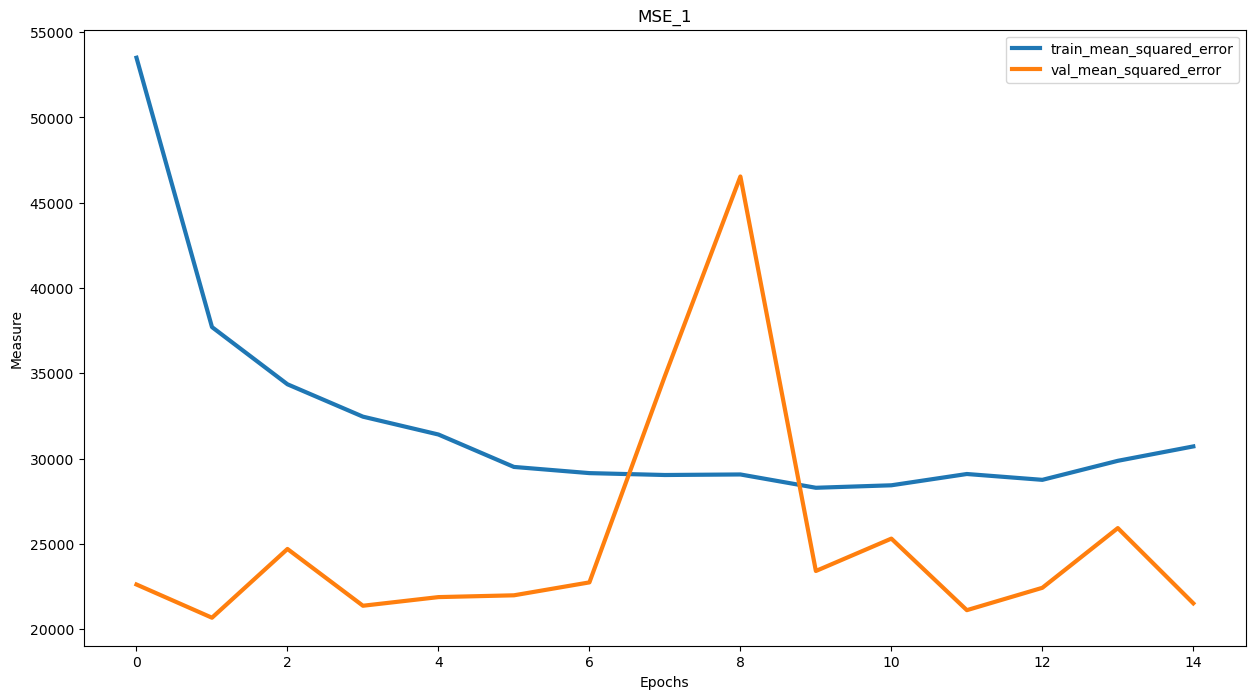

In [23]:
plot_measures_regression(model_name="MNIST-MODEL", history=history, title=f"MSE_{run_count}",accuracy_measures_to_plot=["train_mean_squared_error", "val_mean_squared_error"], savefig=True)

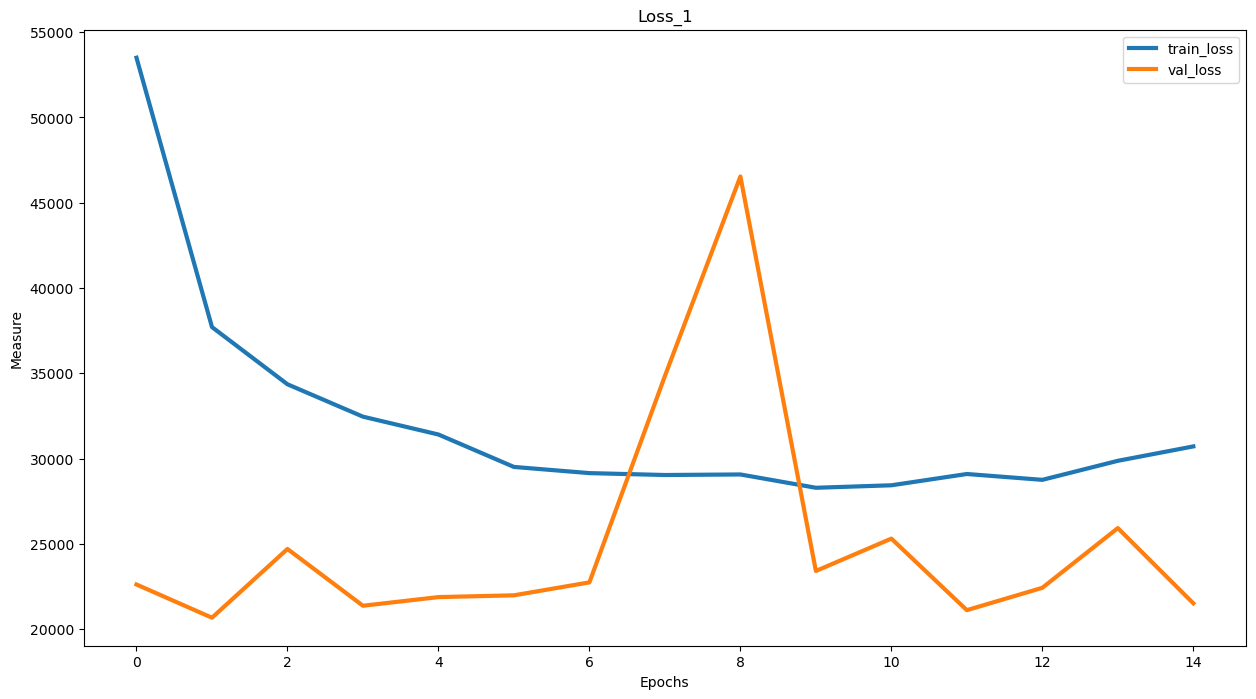

In [24]:
plot_measures_regression(model_name="BOSTON-HOUSING-MODEL", history=history, title=f"Loss_{run_count}", accuracy_measures_to_plot=["train_loss", "val_loss"], savefig=True)

### Modell optimieren <a class="anchor" id="ModellOptimieren"></a>

In [33]:
# Konfiguration des Models (für Hyperparameter-Tuning)
hp = keras_tuner.HyperParameters()  # Keras Tuner Initialisieren
model_config_tuned = {
            "INPUT_SHAPE" : (x_train.shape[1],),
            "HIDDEN_NODES" : [hp.Int('units', 4, 32, 4, default=4), hp.Int('units', 4, 32, 4, default=4)],
            "HIDDEN_ACTIVATION" : hp.Choice("activation", ["relu", "tanh"], default="relu"),
            "OUTPUT_NODES" : 1,
            "OUTPUT_ACTIVATION" : None,
            "WEIGHTS_INITIALIZER" : "random_normal",
            "BIAS_INITIALIZER" : hp.Choice("bias_initializer", ["ones", "zeros"], default="ones"),
            "NORMALIZATION" : "none",
            "OPTIMIZER" : "rmsprop",
            "LEARNING_RATE" : hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=0.01),
            "REGULARIZER" : tf.keras.regularizers.l2(hp.Choice('l2', values=[0.01,0.001,0.1,0.005,0.05])),
            "DROPOUT": True,
            "DROPOUT_RATE" : hp.Float('dropout', min_value=0.01, max_value=0.5, default=0.01, step=0.05),
            "EPOCHS" : 15,
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.2,
            "VERBOSE" : 1,
            "LOSS_FUNCTION" : "mse",
            "METRICS" : hp.Choice("metrics", ["MeanSquaredError", "MeanAbsoluteError"], default="MeanSquaredError")
            }

In [34]:
model_tuned = prepare_model(model_name = "BEIJING-MODEL-TUNED", model_config = model_config_tuned)  # load/prepare model

In [ ]:
# Setup des Tuners
tuner_rs = keras_tuner.RandomSearch(
            model_tuned,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2)

In [ ]:
tuner_rs.search_space_summary()

---

## Referenzen

- Code Snippets/Informationen aus Kurs CDS-108: https://moodle.fhgr.ch/course/view.php?id=14551
- Tensorflow/Keras Doku: https://www.tensorflow.org/datasets/keras_example
- Feature Importance: https://towardsdatascience.com/feature-importance-with-neural-network-346eb6205743
- Hidden Layers: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
- Batches: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
- Batch and Epoch: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
- Batch Size: https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model#:~:text=Generally%20batch%20size%20of%2032,have%20worked%20fine%20for%20me.
- Activation Function: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
- Regularization: https://towardsdatascience.com/regularization-techniques-for-neural-networks-379f5b4c9ac3
- Optimizer: https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- Optimizer wählen: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
- Best optimizer MNIST: https://towardsdatascience.com/neural-network-optimization-algorithms-1a44c282f61d#:~:text=We%20compared%20different%20optimizers%20used,on%20MNIST%20data%20in%20TensorFlow.
- Boston Housing: https://www.kaggle.com/code/manishkc06/build-your-first-deep-learning-model
- Keras Tuner (Hyperparameter Tuning/Optimization): https://keras.io/keras_tuner/

---